# Simple Monotonicity

## Prerequisites

Add the Congrads package to the current Colab notebook environment and install it.

In [42]:
!pip install "congrads[examples]==0.3.0"

Import the necesary functions and classes.

In [43]:
import torch
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from torch.nn import MSELoss, Module
from torch.optim import Adam
from torch.utils.data import Dataset
from IPython.display import clear_output

from congrads.callbacks.base import Callback, CallbackManager
from congrads.constraints.base import Constraint
from congrads.constraints.registry import (
    ANDConstraint,
    ImplicationConstraint,
    RankedMonotonicityConstraint,
    ScalarConstraint,
)
from congrads.core.congradscore import CongradsCore
from congrads.datasets.registry import SyntheticMonotonicity
from congrads.descriptor import Descriptor
from congrads.metrics import MetricManager
from congrads.networks.registry import MLPNetwork
from congrads.utils.utility import (
    CSVLogger,
    Seeder,
    split_data_loaders,
)

Define utility functions for plotting and other.

In [44]:
def plot_regression_epoch(network: Module, dataset: Dataset, device: torch.device):
    fig, ax = plt.subplots(figsize=(6, 4))

    network.eval()
    with torch.no_grad():
        preds = network({"input": dataset.inputs.to(device)})["output"].cpu().numpy().flatten()

    # Plot noisy observations
    ax.scatter(
        dataset.inputs.numpy(),
        dataset.targets.numpy(),
        color="gray",
        alpha=0.6,
        edgecolors="k",
        s=25,
        label="Input data",
    )

    # Plot model prediction
    ax.plot(dataset.inputs.numpy(), preds, "r-", linewidth=2, label="Prediction")

    # Add hatched region
    hatched_area = Rectangle(
        (0.3, 0),  # bottom-left corner
        0.3,  # width
        1,  # height
        facecolor="none",
        edgecolor="green",
        hatch="//",
        linewidth=1,
        alpha=0.7,
        label="Constrained region",
    )
    ax.add_patch(hatched_area)

    # Limit axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Titles and labels
    ax.set_title("Model predictions")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()

    return ax


Before starting with the general training procedure, we fix the randomizer seeds and get the device on which we are training our model:



*   We have a built-in [Seeder class](https://congrads.readthedocs.io/en/latest/api.html#congrads.utils.Seeder) that will pseudo-randomly fix the seeds of random number generators, Numpy and PyTorch.
*   If there is a GPU available, use it. Otherwise fall back to CPU.



In [45]:
# Set seed for reproducibility
seeder = Seeder(base_seed=42)
seeder.set_reproducible()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Problem description

In this first example, the goal is to demonstrate the usage of the Congrads toolbox for a simple monotonicity example.

We aim to fit a regression model to a rising trend that shows local sinusoidal oscillations. The goal is to enforce increasing monotonicity in some part of its domain.

Mathematically: $x_1 \le x_2 \in [0.3,\, 0.6]$, then $f(x_1) \le f(x_2)$

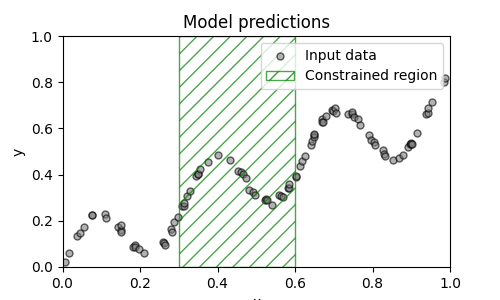

## Dataset

The first important step in the training process is interfacing with your data. Our Congrads toolbox is compatible with the standard [PyTorch Dataset class](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files), but requires the data to be returned in a dictionary format.

We require the returning dictionary to have keys `input` and `target`.


*   `input` holds data that is provided to the network (model) as input
*   `target` holds ground truth data that compared against the predictions to calculate a loss value

The Congrads toolbox holds a [collection of several predefined datasets](https://congrads.readthedocs.io/en/latest/api.html#module-congrads.datasets) which feature automatic downloading or generate synthetic data.


When creating custom datasets, make sure they return data in this format — including the required `input` and `target` keys — while remaining flexible to include any additional keys you need.

```python
class MyData(Dataset):

  ...

  def __getitem__(self, idx) -> dict:
    # The Congrads toolbox expects data in a dictionary format that must include the keys 'input' and 'target'
    return {"input": self.inputs[idx], "target": self.targets[idx]}
```

We provide a [utility wrapper](https://) that can convert any regular dataset into a dataset that returns a Congrads-compatible dictionary.

For this example we will use the built-in [SyntheticMonotonicity dataset](https://) and we will split the dataset into training, validation and test sets using another [built-in utility function](https://).

In [46]:
# Load and preprocess data
dataset = SyntheticMonotonicity(
    n_samples=100,
    x_range=(0, 1),
    osc_amplitude=0.15,
    osc_frequency=20.0,
    osc_prob=1.0,
    noise_base=0.01,
    noise_scale=0.02,
    seed=seeder.roll_seed(),
)
loaders = split_data_loaders(
    dataset,
    loader_args={"batch_size": 10, "shuffle": True},
    valid_loader_args={"shuffle": False},
    test_loader_args={"shuffle": False},
)

## Network

After the data is taken care of, we must define a network (model) to train. Our Congrads toolbox is compatible with any [PyTorch-compatible network](https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html#define-the-class), but again requires the forward pass of the model to return a dictionary format.

Congrads expects the forward pass to update the data dictionary by adding model predictions under the key `output`.

Congrads provides a limited amount of [pre-built networks](https://congrads.readthedocs.io/en/latest/api.html#module-congrads.networks) including a basis fully connected MLP Network, but you can use any network as long as it meets the above requiremtens. When building your own network, it can be done like this:

```python
class MyNetwork(nn.Module):

    ...

    def forward(self, data: dict[str, Tensor]):
        # Congrads expects the forward pass to update the data dictionary by adding model predictions under the key output.
        data["output"] = self.network(data["input"])
        return data
  ```

  Again, we will use a built in fully connected network for this example, define its dimensions and parameters, and then push it to the correct device.

In [47]:
# Instantiate network and push to correct device
network = MLPNetwork(n_inputs=1, n_outputs=1, n_hidden_layers=3, hidden_dim=100)
network = network.to(device)

## Descriptor

Now that we have the dataset and the network defined, we can set up an important feature in the Congrads toolbox, called the `Descriptor`.

The descriptor describes the data that is used with your network. It allows assigning tags to specific parts of data in the network, in order to easily be able to apply constraints on these parts of data.

Example:
```python
descriptor = Descriptor()
descriptor.add("input", "t", 0, constant=True)   # Assigns tag 't' to input data tensor column 0
```

We have [several flags](https://congrads.readthedocs.io/en/latest/api.html#congrads.descriptor.Descriptor.add) when assigning tags to data:

*   `constant=True` is used for data that is not changing, like input data or extra context data like run identifiers. This data stays constant troughout the training.


In [48]:
# Instantiate descriptor
descriptor = Descriptor()

# Add a constant tag for the input
descriptor.add("input", "x", 0, constant=True)

# Add a tag for the output
descriptor.add("output", "y", 0)


## Constraints

With the help of the descriptor, we can easily reference certain parts of the neural network, and so we can now define our constraints.

We have [numerous pre-defined constraints](https://congrads.readthedocs.io/en/latest/api.html#module-congrads.constraints) available that allow a variety of options. Some examples:


*   `ScalarConstraint` allows enforcing that data referenced by a tag should be above or below a certain scalar value
* `ImplicationConstraint` allows conditionally enforcing constraints. If constraint X satisfies, then enforce constraint Y.
*   `MonotonicityConstraint` allows enforcing a monotonic behaviour on a certain tag
* `ANDConstraint` allows enforcing a combination of constraints

With these constraints you can start building up your logic, to start constraining your network predictions.

When defining constraints, you should always start by assigning the descriptor and the device to the constraints globally so every constraint has access to it.
```python
Constraint.descriptor = descriptor
Constraint.device = device
```

Then you can create your list of constraints to enforce. For example, the constraints below enforce that `y` must be less than or equal 1 if `x` is greater than 0.5.

```python
constraints = [
    ImplicationConstraint(
        head=ScalarConstraint("x", torch.gt, 0.5),
        body=ScalarConstraint("y", torch.le, 1.0),
    )
]
```

In this example, we want to enforce a monotonically increasing prediction `y` when the input `x` lays between 0.3 and 0.6 (including).

The objective: $x_1 \le x_2 \in [0.3,\, 0.6]$, then $f(x_1) \le f(x_2)$

In [49]:
# Assign descriptor to constraint base
Constraint.descriptor = descriptor

# Assign device to constraint base
Constraint.device = device

# Define constraints
constraints = [
    ImplicationConstraint(
        head=ANDConstraint(
            ScalarConstraint("x", ">=", 0.3),
            ScalarConstraint("x", "<=", 0.6),
        ),
        body=RankedMonotonicityConstraint("y", "x"),
    ),
]

/usr/local/lib/python3.12/dist-packages/congrads/constraints/base.py:216: UserWarning: Rescale factor for constraint y monotonically (ranked) ascending by x is <= 1. The network will favor general loss over the constraint-adjusted loss. Is this intended behavior? Normally, the rescale factor should always be larger than 1.
  super().__init__({tag_prediction}, name, enforce, 1.0)
/usr/local/lib/python3.12/dist-packages/congrads/constraints/registry.py:102: UserWarning: Rescale factor for constraint y monotonically (ranked) ascending by x if x >= 0.3 AND x <= 0.6 is <= 1. The network will favor general loss over the constraint-adjusted loss. Is this intended behavior? Normally, the rescale factor should always be larger than 1.
  super().__init__(head.tags | body.tags, name, body.enforce, body.rescale_factor)


## Loss and optimizer

We also have to define a loss function and an optimizer.

You can use any [PyTorch loss function](https://docs.pytorch.org/docs/stable/nn.html#loss-functions) that fits your training, or write and implement your own as long as it extends the `nn.Module` class.

We also provide a built-in [ZeroLoss](https://congrads.readthedocs.io/en/latest/api.html#congrads.utils.ZeroLoss) class that can be used for training without loss. This can be used to train your network only based on the constraints. By using this loss function, it will always output zero and thus focus solely on enforcing the constraints for training.

You can use any common optimizer such as `Adam` and `SGD`. PyTorch provides a [collection of optimizers](https://docs.pytorch.org/docs/stable/optim.html) to use.

For this example, we will stick to using MSE loss and the Adam optimizer.

In [50]:
# Instantiate loss and optimizer
criterion = MSELoss()
optimizer = Adam(network.parameters(), lr=0.001)

## Metric manager

To allow keeping track of constraint satisfaction rates for each individual constraints, as well as the losses and possibly other metrics, we set up a [MetricManager](https://congrads.readthedocs.io/en/latest/api.html#module-congrads.metrics) system.

The `CongradsCore` requires a metric manager instance, because it registers and stored metrics internally. You can reference the metric manager in callbacks for custom logging or to store and keep track of the metrics.

In [51]:
# Initialize metric manager
metric_manager = MetricManager()

## Callback manager

At the moment, we have a callback system in place that allows executing customizable functions at certain points in the training process.

This can be used to do some custom data transformations, to generate graphs and figures or to do custom logging functionalities.

Refer to the [Congrads documentation](https://congrads.readthedocs.io/en/latest/) for more info.

In [52]:
callback_manager = CallbackManager()

In [53]:
class PlottingCallback(Callback):
    def on_epoch_end(self, data, ctx):
        clear_output(wait=True)
        plot_regression_epoch(network, dataset, device)
        plt.show()
        plt.close()

In [54]:
callback_manager.add(PlottingCallback())

<CallbackManager callbacks=['PlottingCallback'] ctx_keys=[]>

## Core

The [CongradsCore](https://congrads.readthedocs.io/en/latest/api.html#congrads.core.CongradsCore) is the brain of the toolbox. It orchestrates the functionality of all previously created objects, integrating descriptors, constraints, and optimization strategies to perform constraint-guided gradient descent. Essentially, it manages the full training or evaluation pipeline: preparing input and output tensors, applying constraints, computing gradients, updating model parameters, and generating predictions in a coordinated manner.

In [55]:
# Instantiate core
core = CongradsCore(
    descriptor=descriptor,
    constraints=constraints,
    dataloader_train=loaders[0],
    dataloader_valid=loaders[1],
    dataloader_test=loaders[2],
    network=network,
    callback_manager=callback_manager,
    criterion=criterion,
    optimizer=optimizer,
    metric_manager=metric_manager,
    device=device,
    enforce_all=True,
)

Finally, we can start training by running the `core.fit(...)` function. This function allows setting the maximum epochs and callback functions and will start the training process.

While the Congrads Core implements and abstractizes a standard training loop within, you are not limited to this. Congrads exposes [some static methods](https://congrads.readthedocs.io/en/latest/api.html#congrads.core.CongradsCore.train_step) that you can leverage to implement your own training loop. Particulary useful if you require advanced functionality or are deviating from a standard training procedure.

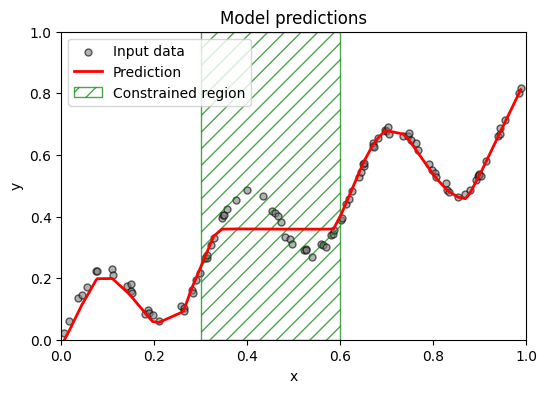

Epoch: 100%|██████████| 500/500 [01:36<00:00,  5.19it/s]


In [56]:
# Start training
core.fit(max_epochs=500)